# WARNING >> !!

 * Always test Run Before Train

In [1]:
with open('/content/Tiny_KSI_.txt', 'r', encoding='utf-8') as file:
    txt = file.read()

chars = sorted(list(set(txt)))
vocabSiz = len(chars)

print(chars)
print(vocabSiz)

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£', 'É', 'à', 'á', 'é', 'í', 'ü', 'Ɛ', 'ɔ', 'е', '\u2005', '\u200b', '‒', '–', '—', '‘', '’', '“', '”', '\u205f']
102


In [2]:
print(len(txt))

215148


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------//
# // Hyper para
batchSiz = 32
blockSiz = 128
epochs = 2800
evalIntervals = 500
lr = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
evelItrs = 200
nEmb = 256
nHead = 4
nLayers = 4
dropout = 0.3
# -----------


# Test Run
#batchSiz = 10
#blockSiz = 25
#epochs = 100
#evalIntervals = 10
#lr = 1e-1
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#evelItrs = 200
#nEmb = 20
#nHead = 1
#nLayers = 1
#dropout = 0.1
#torch.manual_seed(1337)

with open('/content/Tiny_KSI_.txt', 'r', encoding='utf-8') as file:
    txt = file.read()

chars = sorted(list(set(txt)))
vocabSiz = len(chars)

stoi = {ch:i for i, ch in enumerate(chars)}
itos = {i:ch for i, ch in enumerate(chars)}
enc = lambda s: [stoi[c] for c in s]
decod = lambda l: "".join([itos[i] for i in l])

data = torch.tensor(enc(txt), dtype=torch.long)
n = int(0.9*len(data))
trainData = data[:n]
devData = data[n:]

def getBatch(split):
    data = trainData if split == 'train' else devData
    ix = torch.randint(len(data) - blockSiz, (batchSiz, ))

    x = torch.stack([data[i:i+blockSiz] for i in ix])
    y = torch.stack([data[i+1:i+blockSiz+1] for i in ix])#predict nxt token
    x, y = x.to(device), y.to(device)

    return x, y

@torch.no_grad()
def estimateLoss():
    out = { }
    model.eval()
    for split in ['train', 'dev']:
        losses = torch.zeros(evelItrs)

        for k in range(evelItrs):
            X, Y = getBatch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()

        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    def __init__(self, headSiz):
        super(Head, self).__init__()
        self.key = nn.Linear(nEmb, headSiz, bias=False)
        self.quary = nn.Linear(nEmb, headSiz, bias=False)
        self.value = nn.Linear(nEmb, headSiz, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones(blockSiz, blockSiz)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #// input of size (batch, time-step, channels)
        #// output of size (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)
        q = self.quary(x)

        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)

        v = self.value(x)
        out = w @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, nHead, headSiz):
        super(MultiHeadAttention, self).__init__()
        self.heads = nn.ModuleList([Head(headSiz) for _ in range(nHead)])
        self.projection = nn.Linear(headSiz * nHead, nEmb)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.projection(out))
        return out

class FeedForwardNetwork(nn.Module):
    def __init__(self, nEmb):
        super(FeedForwardNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(nEmb, 4 * nEmb),
            nn.ReLU(),
            nn.Linear(4 * nEmb, nEmb),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, nEmb, nHead):
        super(Block, self).__init__()
        headSiz = nEmb // nHead
        self.selfAtn = MultiHeadAttention(nHead, headSiz)
        self.ffn = FeedForwardNetwork(nEmb)
        self.layrNorm_1 = nn.LayerNorm(nEmb)
        self.layrNorm_2 = nn.LayerNorm(nEmb)

    def forward(self, x):
        x = x + self.selfAtn(self.layrNorm_1(x))
        x = x + self.ffn(self.layrNorm_2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super(GPTLanguageModel, self).__init__()
        self.toknEmbTable = nn.Embedding(vocabSiz, nEmb)
        self.posEmbTable = nn.Embedding(blockSiz, nEmb)
        self.blocks = nn.Sequential(*[Block(nEmb, nHead=nHead) for _ in range(nLayers)])
        self.lyrNormFinl = nn.LayerNorm(nEmb)
        self.lmHead = nn.Linear(nEmb, vocabSiz)

        self.apply(self._init_W)

    def _init_W(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def forward(self, ix, targt=None):
        B, T = ix.shape

        tokEmb = self.toknEmbTable(ix)
        posEmb = self.posEmbTable(torch.arange(T, device=device))
        x = tokEmb + posEmb
        x = self.blocks(x)
        x = self.lyrNormFinl(x)
        logits = self.lmHead(x)

        if targt is None:
            loss = None

        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targt = targt.view(B*T)
            loss = F.cross_entropy(logits, targt)

        return logits, loss

    def generate(self, ix, maxNewTokn):
        for i in range(maxNewTokn):
            ixCond = ix[:, -blockSiz:]

            logits, loss = self(ixCond)

            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)

            ixNxt = torch.multinomial(probs, num_samples=1)
            ix = torch.cat((ix, ixNxt), dim=-1)
        return ix

model = GPTLanguageModel()
m = model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr=lr)

lossI = []
for i in range(epochs):

    if i % evalIntervals == 0 or i == epochs - 1:
        losses = estimateLoss()
        lossI.append(losses)

        print(f"Step./ {i}: Train Loss [{losses['train']:.4f}], val/dev Loss [{losses['dev']:.4f}]")

    xb, yb = getBatch('train')

    logits, loss = model(xb, yb)
    optim.zero_grad()
    loss.backward()
    optim.step()


# Save model's state dictionary
torch.save(model.state_dict(), "KsiSongLyricsGEN_1.pth")
print(f'Model Save To KsiSongLyricsGEN_1.pth"')


Step./ 0: Train Loss [4.6566], val/dev Loss [4.6555]
Step./ 500: Train Loss [1.9279], val/dev Loss [2.0214]
Step./ 1000: Train Loss [1.6199], val/dev Loss [1.7923]
Step./ 1500: Train Loss [1.3982], val/dev Loss [1.6717]
Step./ 2000: Train Loss [1.2442], val/dev Loss [1.6431]
Step./ 2500: Train Loss [1.1213], val/dev Loss [1.6290]
Step./ 2799: Train Loss [1.0560], val/dev Loss [1.5778]
Model Save To KsiSongLyricsGEN_1.pth"


In [5]:
# with tiny_Ksi.txt// Also Avoiding Overfitting
contxt = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decod(m.generate(contxt, maxNewTokn=5000)[0].tolist()))


[Oks - Tred & Nichorus]
Coristmas on my G loors
Powed girl 'cause I see my wrong
Now my proor-
No, now I'm champlound
Pawer waving with all yours and that hey frief
Know your comings and teeduss
Got not hace in of consron
When coming my life Leas
God-four fly as nooft
Fiven beature houtted armare Llow
I dess don't can't be here bitchesen them EAF
Your face, Jeezen these nuggy Mile, shem on the dies summmy had (Somear)
I ust her on a hergy, yose (Sumer)
I'm can a queelecoro
They can’t end cud to flear (I don't real)
You hears what hate my man, man? Skrrt (Know), spectashree wanna go
And undecontamong 'em a hijew motorom butty (Not int)
Break to done me whips with a sippine
Bleagh, 'cause I’m the tar crings top on with the sun, controug MN (Brrr)
Beling ting me, I've weenerring in the peodutties (tomok)

[versen 2: KSI & KSI]
Hott up on a crimplayace (Nutta wha shit and like thick, do)
I then I was click s2
Got alie that the Saame, ain't lurbpin' that shout it it
Ready posen, I take a g

In [ ]:
# with tiny_Ksi.txt
contxt = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decod(m.generate(contxt, maxNewTokn=1000)[0].tolist()))


 finght on the 62 were, alway ang out your get (Ayy, ayy)
Whyle winning allazy
My where these I said on me, (ah)
Diving walone is piating to piecal? When then I ain't never your got
I'm int when when ice, it's lifestmenty milessince
Flions, I'm a rollatede killas aP
KSI
Had and gling my oh All
I've bit got runng out their is rol
See wher a the chillines
We I'm sticsitabll me witchen shellybut I don't adver up cold
Walkin' (Ayy, afpop)
So in, I cant me to the luck up, fake up (Yeah)
Andvay money're my bickaying drinks, I'm girldner, finin' Oh lost on (Ooh)
I need poppin' me)
Papin' ta never fuckin', the contem (Or trip)
Sun, here, brom ain't no every men playin' no kin'
This you missin', I don't game
And kneh same
No many gouess, Milline pleft boy Kepin' of the dark
Back, I hen I wanna tin' make F's thance
Everythhing that us on plead
Acinging it (We me)
Everything iving is on plents
I'm sinconnelss ints when no my (Then I'm picking if)
Reciding in, any creply, not and hampless, I'm co

## WOW, Im Quite Happy, This is better that JJ's Lyrics :0
  * Actualy Not bad for this model....

    * About the data file:
      * ok so i didnt Fucking webscrape the Lyrics,,
      
      * Cos Its So Foggy to figure out and I just copy Past

      * But i think The model quite good,, Also the len(char) of txt == >150K
  
  * Also The tiny_Ksi.txt has Small Amout of data
  
### TRain Again with more DATA / Tiny_KSI_.txt
  
  * So i Adjust the para., Cos It's Overfit the data since i scaled the hyper para

  * And i retrain the model with same para i used when i train[# with tiny_Ksi.txt]

  * **The Loss has became down to  Train Loss [1.0560], val/dev Loss [1.5778]**
    + I think this Gen are quit good actualy,

    + Train on balanced data i might think [len(char)== >=200K],

    + ANd overall i think this is a successfull project :)
    


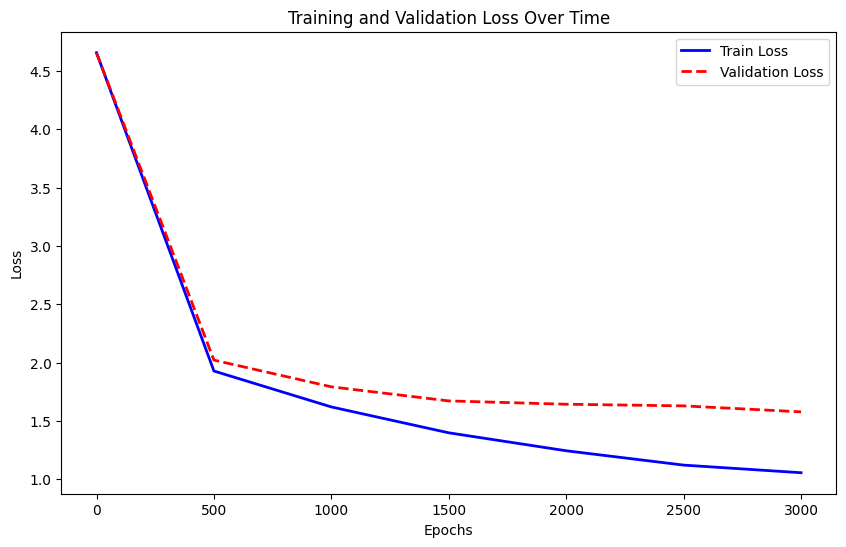

In [6]:
import matplotlib.pyplot as plt

# Assuming lossI is a list of dictionaries with 'train' and 'dev' losses
train_losses = [loss['train'] for loss in lossI]  # Extract training losses
dev_losses = [loss['dev'] for loss in lossI]  # Extract validation losses

# Create a list of steps (epochs) at which the loss is logged
steps = [i * evalIntervals for i in range(len(lossI))]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(steps, dev_losses, label='Validation Loss', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()

# Show the plot
plt.show()
